In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
base_path = '../../'
sys.path.append(base_path)

In [3]:
from torch import nn
import torch
from flow_field_model import create_flow_field_model


model = create_flow_field_model(input_shape=(32, 16, 16), out_channels=5)


In [4]:
from src.pyvista_flow_field_dataset import PyvistaFlowFieldDataset
ds_pv = PyvistaFlowFieldDataset.load_from_huggingface(num_samples=10, data_dir='datasets/pyvista')
#ds_pv= PyvistnormalizationaFlowFieldDataset.try_from_directory("datasets/pyvista",1000)
ds_pv[8].plot_volume("Pressure")

Loaded 10 samples from 'datasets/pyvista'.


2025-05-26 10:18:00.036 (   0.700s) [           49D90]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x11f7cdc80): Skipping BC_t node: BC_t type 'BCInflow' not supported yet.
2025-05-26 10:18:00.036 (   0.700s) [           49D90]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x11f7cdc80): Skipping BC_t node: BC_t type 'BCSymmetryPlane' not supported yet.
2025-05-26 10:18:00.036 (   0.701s) [           49D90]      vtkCGNSReader.cxx:4268  WARN| vtkCGNSReader (0x11f7cdc80): Skipping BC_t node: BC_t type 'BCTunnelOutflow' not supported yet.


Widget(value='<iframe src="http://localhost:59126/index.html?ui=P_0x16c016890_0&reconnect=auto" class="pyvista…

In [5]:
from src.voxel_flow_field_dataset import VoxelFlowFieldDataset, VoxelFlowFieldDatasetConfig
import torch.utils.data
ds_voxel = VoxelFlowFieldDataset('datasets/voxels',VoxelFlowFieldDatasetConfig(ds_pv, resolution=(32,16,16)))
#s_voxel = VoxelFlowFieldDataset('datasets/voxels')
ds_voxel.normalize()

Voxelizing samples: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


In [6]:
num_train_samples = int(len(ds_voxel) * 0.8)
num_val_samples = len(ds_voxel) - num_train_samples
ds_voxel.shuffle()
train_dataset = ds_voxel[:num_train_samples]
val_dataset = ds_voxel[num_train_samples:]

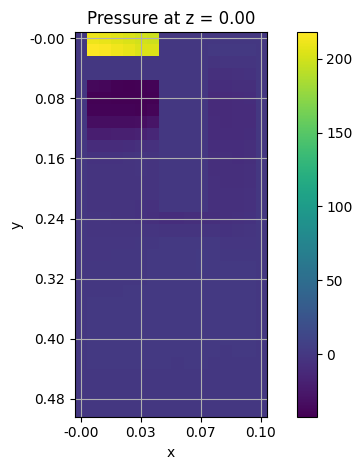

In [7]:
val_dataset[0].plot_slice("Pressure",slice_idx=3)

In [8]:

import torch.utils.data as data
train_dataloader = data.DataLoader(train_dataset.get_default_loadable_dataset(), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
val_dataloader = data.DataLoader(val_dataset.get_default_loadable_dataset(), batch_size=128, shuffle=False, num_workers=0, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
len(train_dataset), len(val_dataset)

(8, 2)

In [9]:
next(iter(train_dataloader))[0].shape

torch.Size([8, 32, 16, 16])

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
print(f"Using device: {device}")
model.to(device)
criterion = nn.MSELoss()
lr=1e-3
epochs=200
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

training_losses = []
validation_losses = []

    
for epoch in range(epochs):
    if (epoch) % 10 == 0:
        val_loss = 0
        train_loss_in_eval = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_dataloader:
                x, y = x.to(device), y.to(device)
                x = x.float().unsqueeze(-1)
                x = x.permute(0, 4, 1, 2, 3)
                y = y.permute(0, 4, 1, 2, 3)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
            for x, y in train_dataloader:
                x, y = x.to(device), y.to(device)
                x = x.float().unsqueeze(-1)
                x = x.permute(0, 4, 1, 2, 3)
                y = y.permute(0, 4, 1, 2, 3)
                outputs = model(x)
                loss = criterion(outputs, y)
                train_loss_in_eval += loss.item()


        print(f"Epoch {epoch}/{epochs}, Loss: {train_loss_in_eval / len(train_dataloader)}, Val Loss: {val_loss / len(val_dataloader)}")
        training_losses.append(train_loss_in_eval / len(train_dataloader))
        validation_losses.append(val_loss / len(val_dataloader))
    model.train()
    epoch_loss = 0
    for x,y in train_dataloader:
        x, y = x.to(device), y.to(device)
        x=x.float().unsqueeze(-1)
        x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
        y = y.permute(0, 4, 1, 2, 3)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / len(train_dataloader)}")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()
# Save the model
torch.save(model.state_dict(), 'unet3d.pth')

Using device: cpu
Epoch 0/200, Loss: 2.987614154815674, Val Loss: 2.159010410308838
Epoch 0/200, Loss: 7.555058479309082
Epoch 1/200, Loss: 5.576682090759277
Epoch 2/200, Loss: 4.528840065002441
Epoch 3/200, Loss: 3.936018466949463
Epoch 4/200, Loss: 3.522618055343628
Epoch 5/200, Loss: 3.209951877593994
Epoch 6/200, Loss: 2.9597458839416504
Epoch 7/200, Loss: 2.751896381378174
Epoch 8/200, Loss: 2.569530725479126
Epoch 9/200, Loss: 2.4031357765197754
Epoch 10/200, Loss: 3.363981246948242, Val Loss: 3.062102794647217
Epoch 10/200, Loss: 2.2518649101257324
Epoch 11/200, Loss: 2.116842031478882
Epoch 12/200, Loss: 1.9982036352157593
Epoch 13/200, Loss: 1.8933769464492798
Epoch 14/200, Loss: 1.7981799840927124
Epoch 15/200, Loss: 1.7109549045562744
Epoch 16/200, Loss: 1.633634328842163
Epoch 17/200, Loss: 1.566684365272522
Epoch 18/200, Loss: 1.5053608417510986
Epoch 19/200, Loss: 1.446012258529663
Epoch 20/200, Loss: 1.7464357614517212, Val Loss: 1.8580560684204102
Epoch 20/200, Loss: 1.

In [13]:
model.load_state_dict(torch.load('unet3d.pth', map_location=device))
model.to(device)
model.eval()

UNet3D(
  (analysis_blocks): ModuleList(
    (0): Conv3DBlock(
      (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Conv3DBlock(
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pooling): MaxPool3d(kernel_size=

In [242]:
mask,y = next(iter(train_dataloader))
mask = mask.to(device)
y = y.to(device)

In [243]:
x=mask.float().unsqueeze(-1)
x = x.permute(0, 4, 1, 2, 3)  # (N, D, H, W, C) → (N, C, D, H, W)
#y = y.permute(0, 4, 1, 2, 3)
y_pred = model(x)
y_pred = y_pred.permute(0, 2, 3, 4, 1)  # (N, C, D, H, W) → (N, D, H, W, C)


In [244]:
y.mean()

tensor(0.0104, device='cuda:0')

In [245]:
y_pred.mean()

tensor(-0.0105, device='cuda:0', grad_fn=<MeanBackward0>)

In [246]:
pred_sample = ds_voxel.prediction_to_sample(mask[0], y_pred[0])

In [247]:
pred_sample.get_field("Pressure").mean()

tensor(-0.0820)

In [248]:
pred_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:32959/index.html?ui=P_0x7de79c29af10_39&reconnect=auto" class="pyv…

In [249]:
true_sample = ds_voxel.prediction_to_sample(mask[0], y[0])
true_sample.plot("Pressure")

Widget(value='<iframe src="http://localhost:32959/index.html?ui=P_0x7de5846ae710_40&reconnect=auto" class="pyv…

In [250]:
true_sample.get_field("Pressure").mean(), pred_sample.get_field("Pressure").mean()

(tensor(0.0993), tensor(-0.0820))

In [251]:
pred_sample.data["Pressure"].std()

tensor(17.8941)

In [252]:
pred_sample.plot_slice_interactively("Pressure",axis="z")

interactive(children=(IntSlider(value=8, description='slice_idx', max=15), Output()), _dom_classes=('widget-in…

In [253]:
true_sample.data["Pressure"].min()

tensor(-59.0414)

In [254]:
true_sample.plot_slice_interactively("Pressure", axis="z")

interactive(children=(IntSlider(value=8, description='slice_idx', max=15), Output()), _dom_classes=('widget-in…